In [1]:
import torch
import torchvision
import torchvision.transforms as T
import os
# from train_utils import evaluate
from torch.utils.tensorboard import SummaryWriter
import pandas as pd
from torch.utils.data import Dataset, DataLoader
# from PIL import Image
import argparse 
import yaml
from types import SimpleNamespace
# from tqdm import tqdm
from utils import train_one_epoch, evaluate, Task2Dataset, write_tb
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt



In [2]:

def main(args):

    data_transforms = T.Compose([
        T.Resize((args.img_size, args.img_size)),
        T.ToTensor(),
    ])

    test_dataset = Task2Dataset(args.test_csv_path, transform=data_transforms)
    test_loader = DataLoader(test_dataset, batch_size=args.batch_size,shuffle=False, num_workers=args.num_workers)


    device = torch.device("cuda" if torch.cuda.is_available else "cpu")

    print("Loading model...")
    if args.model == "resnet18":
        model = torchvision.models.resnet18().to(device)
    elif args.model == "mobilenet":
        model = torchvision.models.mobilenet_v3_large().to(device)
    
    try:
        model.fc = torch.nn.Sequential(
            torch.nn.Linear(
                in_features = model.fc.in_features,
                # out_features = 1,
                out_features = args.num_classes,
                
            )
        ).to(device)
    except: # for mobilenet
        model.classifier[-1] = torch.nn.Sequential(
            torch.nn.Linear(
                in_features = model.classifier[-1].in_features,
                # out_features = 1,
                out_features = args.num_classes,
                
            )
        ).to(device)

    # last_saved_weights_path = f'model-98-trainLoss-0.0354666572970313.pth'

    last_saved_weights_path = sorted(os.listdir(f"./runs/{args.model}/weights/"))[-1]
    if args.augmentation and args.from_scratch:
        last_saved_weights_path = f'{args.model}_aug_scratch.pth'
        # last_saved_weights_path = f'model-98-trainLoss-0.011288848060827989.pth'
        # last_saved_weights_path = f'model-48-trainLoss-0.018568319770006034.pth'        
    elif args.augmentation and not args.from_scratch:
        # last_saved_weights_path = f'model-96-trainLoss-0.02599354913911304.pth'
        # last_saved_weights_path = f'model-98-trainLoss-0.0354666572970313.pth'
        last_saved_weights_path = f'{args.model}_aug.pth'  
    elif not args.augmentation:
        last_saved_weights_path = f'{args.model}_no_aug.pth'

    # print(sorted(os.listdir(f"./runs/{args.model}/weights/")))
    print(f'loading {os.path.join(f"./runs/{args.model}/weights/", last_saved_weights_path)}...')
    # last_saved_weights_path = "model-18-trainLoss-0.026115660484020527.pth"
    checkpoint = torch.load(os.path.join(f"./runs/{args.model}/weights/", last_saved_weights_path))
    model.load_state_dict(checkpoint["model"])

    eval_acc, eval_f1, cm, cls_report = evaluate(model, test_loader, device)
    return eval_acc, eval_f1, cm, cls_report




Loading model...
loading ./runs/resnet18/weights/resnet18_no_aug.pth...
Model performance:
--- Accuracy: 0.929347813129425
--- F1 score (weighted): 0.9217918411363997
 
--- Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.59      0.75       160
           1       0.92      1.00      0.96       760

    accuracy                           0.93       920
   macro avg       0.96      0.80      0.85       920
weighted avg       0.93      0.93      0.92       920

 
--- Confusion Matrix: 
[[ 95  65]
 [  0 760]]


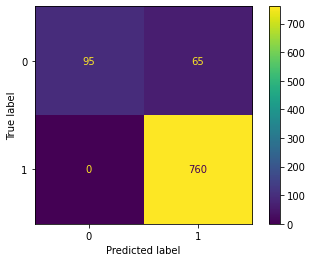

In [15]:

# MODEL_NAME = "mobilenet"
# MODEL_NAME = "resnet50"
# MODEL_NAME = "vgg"
MODEL_NAME = "resnet18"



yml_args = yaml.load(open(os.path.join("./config", f'{MODEL_NAME}.yml')), Loader=yaml.FullLoader)
yml_args["model"] = MODEL_NAME
yml_args["augmentation"] = False
yml_args["from_scratch"] = True
args = SimpleNamespace(**yml_args)
eval_acc, eval_f1, cm, cls_report = main(args)

print("Model performance:")
print(f"--- Accuracy: {eval_acc}")
print(f"--- F1 score (weighted): {eval_f1}")
print(" ")
print(f"--- Classification Report:")
print(cls_report)
print(" ")
print(f"--- Confusion Matrix: ")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])

disp.plot()
print(cm)

Loading model...
loading ./runs/resnet18/weights/resnet18_aug_scratch.pth...
Model performance:
--- Accuracy: 0.9326087236404419
--- F1 score (weighted): 0.9269242383900195
 
--- Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.64      0.77       160
           1       0.93      0.99      0.96       760

    accuracy                           0.93       920
   macro avg       0.95      0.82      0.86       920
weighted avg       0.93      0.93      0.93       920

 
--- Confusion Matrix: 
[[102  58]
 [  4 756]]


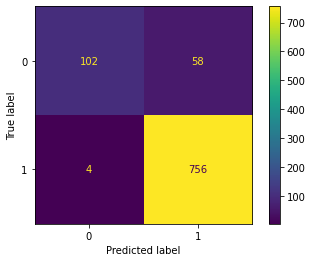

In [16]:
MODEL_NAME = "resnet18"

yml_args = yaml.load(open(os.path.join("./config", f'{MODEL_NAME}.yml')), Loader=yaml.FullLoader)
yml_args["model"] = MODEL_NAME
yml_args["augmentation"] = True
yml_args["from_scratch"] = True
args = SimpleNamespace(**yml_args)
eval_acc, eval_f1, cm, cls_report = main(args)

print("Model performance:")
print(f"--- Accuracy: {eval_acc}")
print(f"--- F1 score (weighted): {eval_f1}")
print(" ")
print(f"--- Classification Report:")
print(cls_report)
print(" ")
print(f"--- Confusion Matrix: ")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])

disp.plot()
print(cm)

Loading model...
loading ./runs/resnet18/weights/resnet18_aug.pth...
Model performance:
--- Accuracy: 0.9630434513092041
--- F1 score (weighted): 0.9614895777917494
 
--- Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.80      0.88       160
           1       0.96      1.00      0.98       760

    accuracy                           0.96       920
   macro avg       0.97      0.90      0.93       920
weighted avg       0.96      0.96      0.96       920

 
--- Confusion Matrix: 
[[128  32]
 [  2 758]]


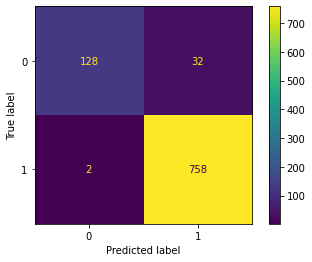

In [17]:
MODEL_NAME = "resnet18"

yml_args = yaml.load(open(os.path.join("./config", f'{MODEL_NAME}.yml')), Loader=yaml.FullLoader)
yml_args["model"] = MODEL_NAME
yml_args["augmentation"] = True
yml_args["from_scratch"] = False
args = SimpleNamespace(**yml_args)
eval_acc, eval_f1, cm, cls_report = main(args)

print("Model performance:")
print(f"--- Accuracy: {eval_acc}")
print(f"--- F1 score (weighted): {eval_f1}")
print(" ")
print(f"--- Classification Report:")
print(cls_report)
print(" ")
print(f"--- Confusion Matrix: ")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])

disp.plot()
print(cm)

Loading model...
loading ./runs/mobilenet/weights/mobilenet_aug_scratch.pth...
Model performance:
--- Accuracy: 0.97826087474823
--- F1 score (weighted): 0.9776773950686993
 
--- Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.88      0.93       160
           1       0.97      1.00      0.99       760

    accuracy                           0.98       920
   macro avg       0.99      0.94      0.96       920
weighted avg       0.98      0.98      0.98       920

 
--- Confusion Matrix: 
[[140  20]
 [  0 760]]


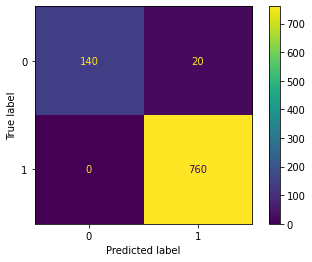

In [18]:
MODEL_NAME = "mobilenet"

yml_args = yaml.load(open(os.path.join("./config", f'{MODEL_NAME}.yml')), Loader=yaml.FullLoader)
yml_args["model"] = MODEL_NAME
yml_args["augmentation"] = True
yml_args["from_scratch"] = True
args = SimpleNamespace(**yml_args)
eval_acc, eval_f1, cm, cls_report = main(args)

print("Model performance:")
print(f"--- Accuracy: {eval_acc}")
print(f"--- F1 score (weighted): {eval_f1}")
print(" ")
print(f"--- Classification Report:")
print(cls_report)
print(" ")
print(f"--- Confusion Matrix: ")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])

disp.plot()
print(cm)

Loading model...
loading ./runs/mobilenet/weights/mobilenet_aug.pth...
Model performance:
--- Accuracy: 0.977173924446106
--- F1 score (weighted): 0.9765943901434295
 
--- Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.88      0.93       160
           1       0.97      1.00      0.99       760

    accuracy                           0.98       920
   macro avg       0.98      0.94      0.96       920
weighted avg       0.98      0.98      0.98       920

 
--- Confusion Matrix: 
[[140  20]
 [  1 759]]


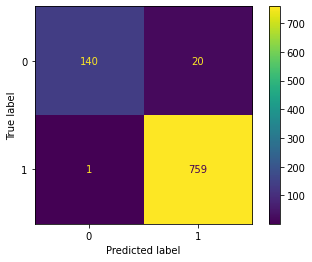

In [19]:
MODEL_NAME = "mobilenet"

yml_args = yaml.load(open(os.path.join("./config", f'{MODEL_NAME}.yml')), Loader=yaml.FullLoader)
yml_args["model"] = MODEL_NAME
yml_args["augmentation"] = True
yml_args["from_scratch"] = False
args = SimpleNamespace(**yml_args)
eval_acc, eval_f1, cm, cls_report = main(args)

print("Model performance:")
print(f"--- Accuracy: {eval_acc}")
print(f"--- F1 score (weighted): {eval_f1}")
print(" ")
print(f"--- Classification Report:")
print(cls_report)
print(" ")
print(f"--- Confusion Matrix: ")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])

disp.plot()
print(cm)

## Load and plot tensorboard logs

In [20]:
from tbparse import SummaryReader
import os
import matplotlib.pyplot as plt

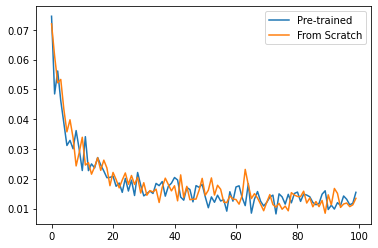

In [34]:
model = "mobilenet"
myevents = [i for i in os.listdir(f"./runs/{model}") if i.startswith("event") ]
# print(myevents)
path = os.path.join(f"./runs/{model}", myevents[1])
reader = SummaryReader(path)
df = reader.scalars
plt.plot(list(range(len(df.value.to_list()))), df.value.to_list())

path = os.path.join(f"./runs/{model}", myevents[-2])
reader = SummaryReader(path)
df = reader.scalars
plt.plot(list(range(len(df.value.to_list()))), df.value.to_list())
plt.legend(["Pre-trained", "From Scratch"])
plt.show()

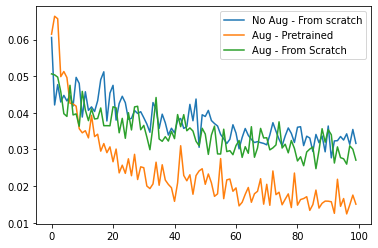

In [42]:
model = "resnet18"
myevents = [i for i in os.listdir(f"./runs/{model}") if i.startswith("event") ]
# print(myevents)
path = os.path.join(f"./runs/{model}", myevents[2])
reader = SummaryReader(path)
df = reader.scalars
plt.plot(list(range(len(df.value.to_list()))), df.value.to_list())

path = os.path.join(f"./runs/{model}", myevents[3])
reader = SummaryReader(path)
df = reader.scalars
plt.plot(list(range(len(df.value.to_list()))), df.value.to_list())

path = os.path.join(f"./runs/{model}", myevents[4])
reader = SummaryReader(path)
df = reader.scalars
plt.plot(list(range(len(df.value.to_list()))), df.value.to_list())

plt.legend(["No Aug - From scratch","Aug - Pretrained","Aug - From Scratch"])
plt.show()